In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, roc_curve, auc
import matplotlib.pyplot as plt

# Load CSV file with a different encoding
df = pd.read_csv('/content/water_dataX.csv', encoding='ISO-8859-1')

# Convert relevant columns to numeric, forcing errors to NaN
columns_to_convert = ['D.O. (mg/l)', 'PH', 'CONDUCTIVITY (µmhos/cm)',
                      'NITRATENAN N+ NITRITENANN (mg/l)', 'B.O.D. (mg/l)',
                      'FECAL COLIFORM (MPN/100ml)', 'TOTAL COLIFORM (MPN/100ml)Mean']
for col in columns_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Handle missing values by filling with mean
imputer = SimpleImputer(strategy='mean')
df[columns_to_convert] = imputer.fit_transform(df[columns_to_convert])

# Define constants
VIdeal = {
    'D.O. (mg/l)': 14.6, 'PH': 7.0, 'CONDUCTIVITY (µmhos/cm)': 0,
    'NITRATENAN N+ NITRITENANN (mg/l)': 0, 'B.O.D. (mg/l)': 0,
    'FECAL COLIFORM (MPN/100ml)': 0, 'TOTAL COLIFORM (MPN/100ml)Mean': 0
}
Si = {
    'D.O. (mg/l)': 10, 'PH': 8.5, 'CONDUCTIVITY (µmhos/cm)': 1000,
    'NITRATENAN N+ NITRITENANN (mg/l)': 45, 'B.O.D. (mg/l)': 5,
    'FECAL COLIFORM (MPN/100ml)': 100, 'TOTAL COLIFORM (MPN/100ml)Mean': 1000
}

def calculate_qi(Vi, parameter):
    if pd.isna(Vi):
        return 0
    return 100 * (Vi - VIdeal[parameter]) / (Si[parameter] - VIdeal[parameter])

def calculate_wi(parameter):
    k = 1 / sum(Si.values())
    return k * Si[parameter]

parameters = ['D.O. (mg/l)', 'PH', 'CONDUCTIVITY (µmhos/cm)',
              'NITRATENAN N+ NITRITENANN (mg/l)', 'B.O.D. (mg/l)',
              'FECAL COLIFORM (MPN/100ml)', 'TOTAL COLIFORM (MPN/100ml)Mean']

for param in parameters:
    df[f'qi_{param}'] = df[param].apply(lambda x: calculate_qi(x, param))
    df[f'wi_{param}'] = calculate_wi(param)

def calculate_wqi(row):
    qi_columns = [f'qi_{param}' for param in parameters]
    wi_columns = [f'wi_{param}' for param in parameters]

    numerator = sum(row[qi_columns[i]] * row[wi_columns[i]] for i in range(len(parameters)))
    denominator = sum(row[wi_columns])

    return numerator / denominator

df['WQI'] = df.apply(calculate_wqi, axis=1)

def categorize_wqi(wqi):
    if wqi <= 25:
        return 'Clean'
    elif 26 <= wqi <= 50:
        return 'Unclean'
    elif 51 <= wqi <= 75:
        return 'Polluted'
    else:
        return 'Highly polluted'

df['WQI_Category'] = df['WQI'].apply(categorize_wqi)

# Feature Engineering: Add polynomial features
features = ['D.O. (mg/l)', 'PH', 'CONDUCTIVITY (µmhos/cm)',
            'NITRATENAN N+ NITRITENANN (mg/l)', 'B.O.D. (mg/l)',
            'FECAL COLIFORM (MPN/100ml)', 'TOTAL COLIFORM (MPN/100ml)Mean']
X = df[features]
y = df['WQI_Category']

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X.to_numpy())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

**SVM CLASSIFIER**

Accuracy: 0.6688963210702341
Precision: 0.606125361539241
Recall: 0.6688963210702341
F1 Score: 0.6234398244521874
ROC AUC: 0.604310922567636
Average Precision: 0.5556000780286069


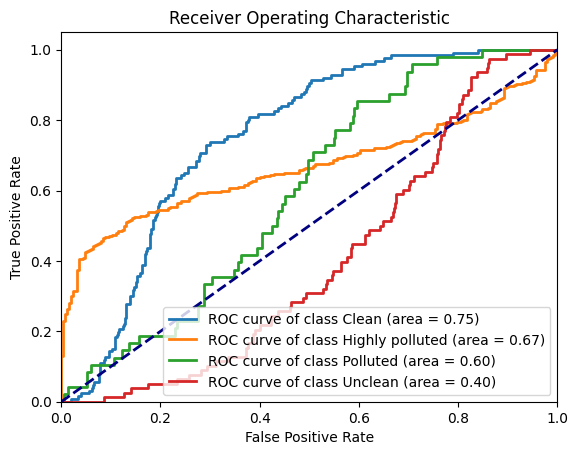

In [ ]:
from sklearn.svm import SVC
svm_model = SVC(probability=True)

# Hyperparameter Tuning
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

grid_search = GridSearchCV(svm_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Best model
best_svm_model = grid_search.best_estimator_
best_svm_model.fit(X_train, y_train)

# Predictions
y_pred = best_svm_model.predict(X_test)
y_prob = best_svm_model.predict_proba(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
avg_precision = average_precision_score(y_test, y_prob, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")
print(f"Average Precision: {avg_precision}")

# ROC Curve
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(best_svm_model.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_prob[:, i], pos_label=best_svm_model.classes_[i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(len(best_svm_model.classes_)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve of class {best_svm_model.classes_[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


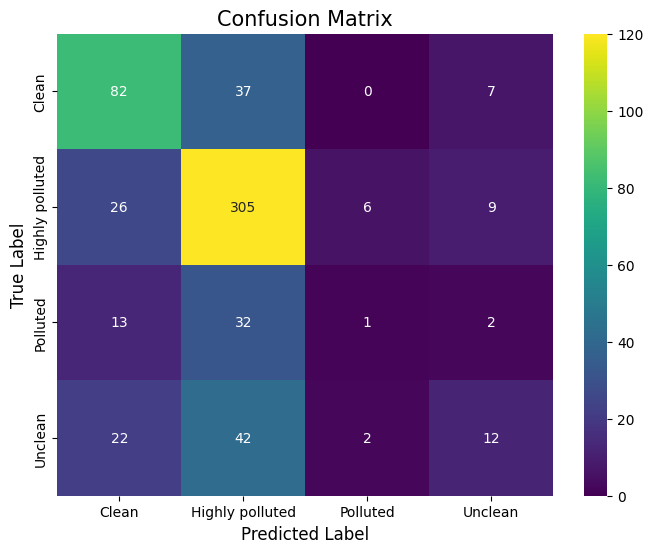

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
class_labels = best_svm_model.classes_  # Assuming y_test is not encoded, else decode it here

# Plot the confusion matrix with heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=True,
            xticklabels=class_labels, yticklabels=class_labels, vmin=0, vmax=120)

# Add labels and title to match the provided image
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=15)

# Display the plot
plt.show()


**RandomForestClassifier**

Accuracy: 0.9515050167224081
Precision: 0.9539079753088309
Recall: 0.9515050167224081
F1 Score: 0.9519305065160933
ROC AUC: 0.9946479481809367
Average Precision: 0.9852787443316409


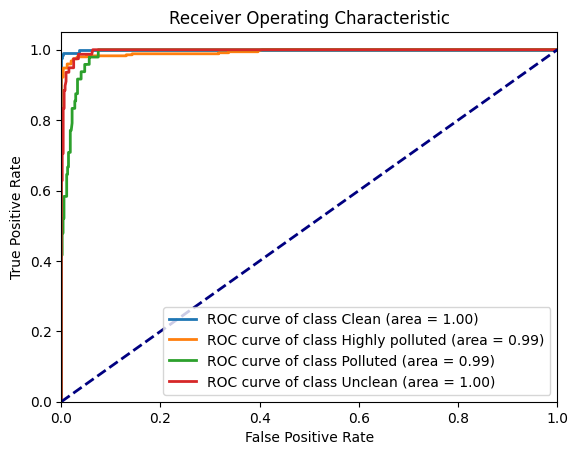

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Define Random Forest model with provided parameters
rf_model = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0,
    max_samples=None
)

# Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 3, 4]
}

grid_search = GridSearchCV(rf_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Best model
best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train, y_train)

# Predictions
y_pred = best_rf_model.predict(X_test)
y_prob = best_rf_model.predict_proba(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
avg_precision = average_precision_score(y_test, y_prob, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")
print(f"Average Precision: {avg_precision}")

# ROC Curve
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(best_rf_model.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_prob[:, i], pos_label=best_rf_model.classes_[i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(len(best_rf_model.classes_)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve of class {best_rf_model.classes_[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


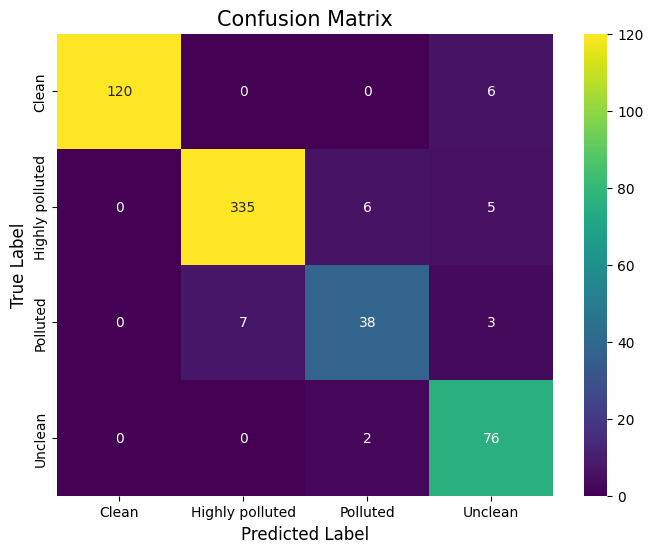

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
class_labels = best_svm_model.classes_  # Assuming y_test is not encoded, else decode it here

# Plot the confusion matrix with heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=True,
            xticklabels=class_labels, yticklabels=class_labels, vmin=0, vmax=120)

# Add labels and title to match the provided image
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=15)

# Display the plot
plt.show()


**MLP Classifier**

Accuracy: 0.7023411371237458
Precision: 0.6298967822240534
Recall: 0.7023411371237458
F1 Score: 0.6574987781304276
ROC AUC: 0.8271750602479325
Average Precision: 0.7426732083678979


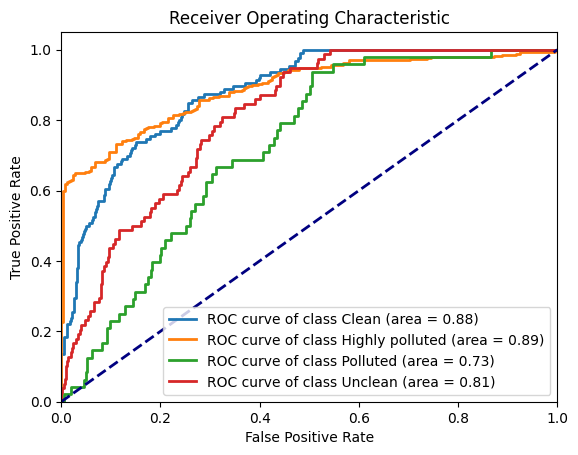

In [ ]:
from sklearn.neural_network import MLPClassifier

# Define MLP model
mlp_model = MLPClassifier(
    hidden_layer_sizes=(100,),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size='auto',
    learning_rate='constant',
    learning_rate_init=0.001,
    power_t=0.5,
    max_iter=50000,
    shuffle=True,
    random_state=None,
    tol=0.0001,
    verbose=False,
    warm_start=False,
    momentum=0.9,
    nesterovs_momentum=True,
    early_stopping=False,
    validation_fraction=0.1,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-8,
    n_iter_no_change=10,
    max_fun=15000
)

# Hyperparameter Tuning
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (150,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

grid_search = GridSearchCV(mlp_model, param_grid, cv=3)
grid_search.fit(X_train, y_train)

# Best model
best_mlp_model = grid_search.best_estimator_
best_mlp_model.fit(X_train, y_train)

# Predictions
y_pred = best_mlp_model.predict(X_test)
y_prob = best_mlp_model.predict_proba(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
avg_precision = average_precision_score(y_test, y_prob, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")
print(f"Average Precision: {avg_precision}")

# ROC Curve
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(best_mlp_model.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_prob[:, i], pos_label=best_mlp_model.classes_[i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(len(best_mlp_model.classes_)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve of class {best_mlp_model.classes_[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



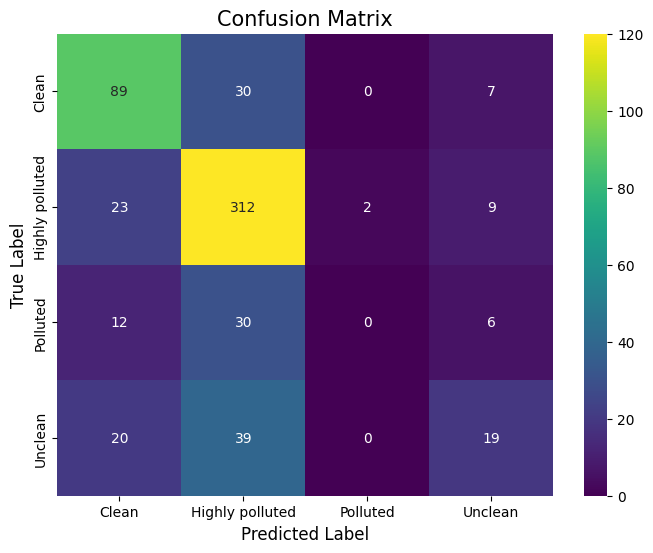

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
class_labels = best_svm_model.classes_  # Assuming y_test is not encoded, else decode it here

# Plot the confusion matrix with heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=True,
            xticklabels=class_labels, yticklabels=class_labels, vmin=0, vmax=120)

# Add labels and title to match the provided image
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=15)

# Display the plot
plt.show()


**Logistic Regression**

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.6270903010033445
Precision: 0.5502551608810979
Recall: 0.6270903010033445
F1 Score: 0.5462803877304447
ROC AUC: 0.7691596114501704
Average Precision: 0.6723231398810348


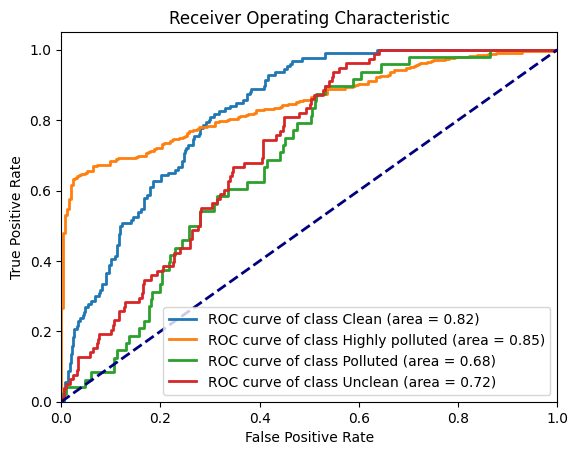

In [ ]:
from sklearn.linear_model import LogisticRegression


# Define Logistic Regression model with provided parameters
logistic_model = LogisticRegression(
    penalty='l2',
    dual=False,
    tol=0.0001,
    C=1.0,
    fit_intercept=True,
    intercept_scaling=1,
    class_weight=None,
    random_state=None,
    solver='lbfgs',
    max_iter=100,
    multi_class='auto',
    verbose=0,
    warm_start=False,
    n_jobs=None,
    l1_ratio=None
)

logistic_model.fit(X_train, y_train)

# Predictions
y_pred = logistic_model.predict(X_test)
y_prob = logistic_model.predict_proba(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
avg_precision = average_precision_score(y_test, y_prob, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")
print(f"Average Precision: {avg_precision}")

# ROC Curve
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(logistic_model.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_prob[:, i], pos_label=logistic_model.classes_[i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(len(logistic_model.classes_)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve of class {logistic_model.classes_[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


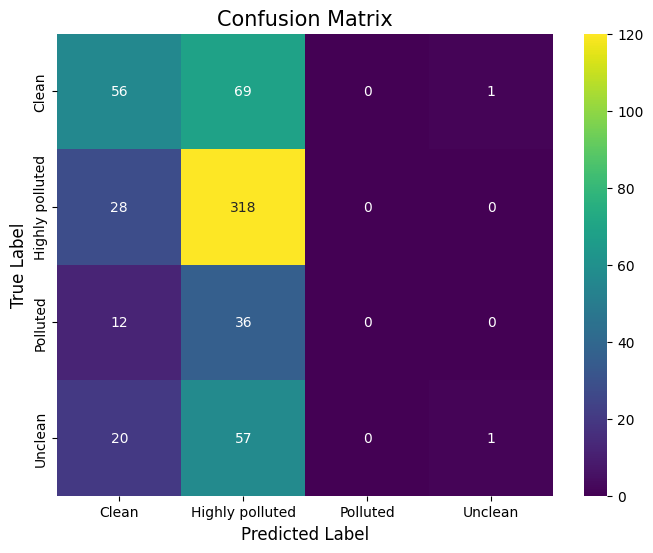

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
class_labels = best_svm_model.classes_  # Assuming y_test is not encoded, else decode it here

# Plot the confusion matrix with heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=True,
            xticklabels=class_labels, yticklabels=class_labels, vmin=0, vmax=120)

# Add labels and title to match the provided image
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=15)

# Display the plot
plt.show()


**XGB Classifier**

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:30:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9481605351170569
Precision: 0.9506790240066658
Recall: 0.9481605351170569
F1 Score: 0.9486795028501096
ROC AUC: 0.9947233124229091
Average Precision: 0.9850376092738374


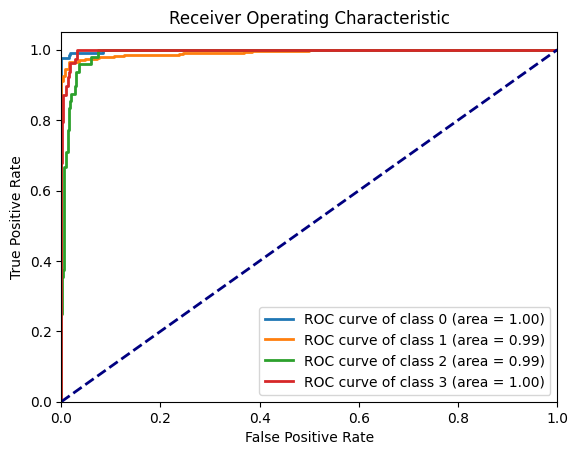

In [ ]:
from xgboost import XGBClassifier

# Encode the categorical labels to numeric
label_encoder = LabelEncoder()
df['WQI_Category'] = label_encoder.fit_transform(df['WQI_Category'])


# Feature Engineering: Add polynomial features
features = ['D.O. (mg/l)', 'PH', 'CONDUCTIVITY (µmhos/cm)',
            'NITRATENAN N+ NITRITENANN (mg/l)', 'B.O.D. (mg/l)',
            'FECAL COLIFORM (MPN/100ml)', 'TOTAL COLIFORM (MPN/100ml)Mean']
X = df[features]
y = df['WQI_Category']

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X.to_numpy())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


# Define XGBoost model with provided parameters
xgb_model = XGBClassifier(
    booster='gbtree',
    verbosity=1,
    validate_parameters=False,
    use_label_encoder=False,
    disable_default_eval_metric=False
)

xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
avg_precision = average_precision_score(y_test, y_prob, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")
print(f"Average Precision: {avg_precision}")

# ROC Curve
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(xgb_model.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_prob[:, i], pos_label=xgb_model.classes_[i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(len(xgb_model.classes_)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve of class {xgb_model.classes_[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


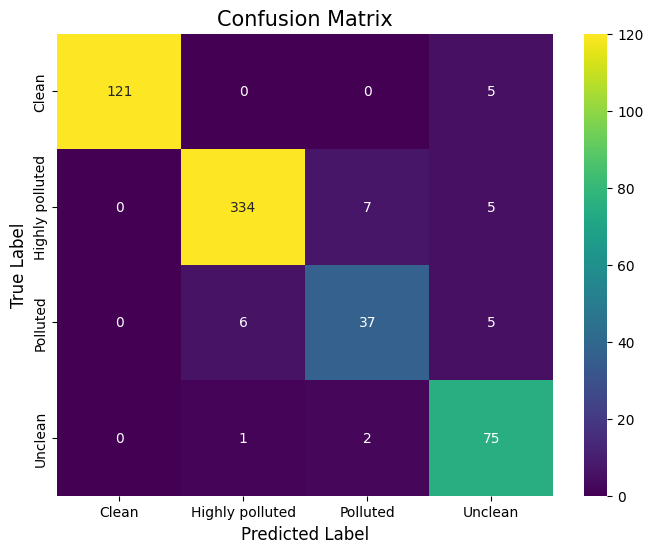

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
class_labels = best_svm_model.classes_  # Assuming y_test is not encoded, else decode it here

# Plot the confusion matrix with heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=True,
            xticklabels=class_labels, yticklabels=class_labels, vmin=0, vmax=120)

# Add labels and title to match the provided image
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=15)

# Display the plot
plt.show()


**Decision Tree Classifier**

Accuracy: 0.9280936454849499
Precision: 0.9280001661689468
Recall: 0.9280936454849499
F1 Score: 0.9279123035485797
ROC AUC: 0.9233268664139329
Average Precision: 0.885452715847462


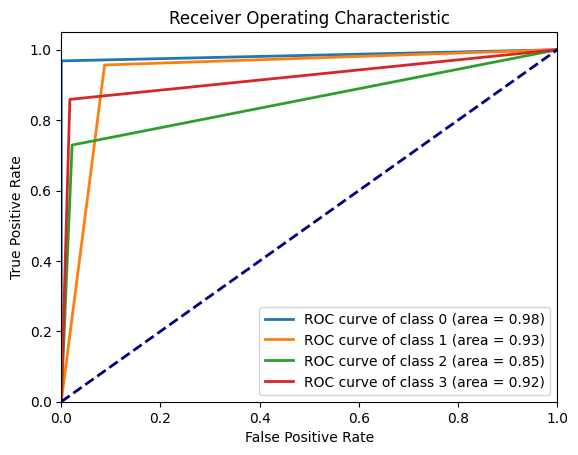

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Define Decision Tree model with provided parameters
dt_model = DecisionTreeClassifier(
    criterion='gini',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0,
    class_weight=None,
    ccp_alpha=0
)

dt_model.fit(X_train, y_train)

# Predictions
y_pred = dt_model.predict(X_test)
y_prob = dt_model.predict_proba(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
avg_precision = average_precision_score(y_test, y_prob, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")
print(f"Average Precision: {avg_precision}")

# ROC Curve
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(dt_model.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_prob[:, i], pos_label=dt_model.classes_[i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(len(dt_model.classes_)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve of class {dt_model.classes_[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


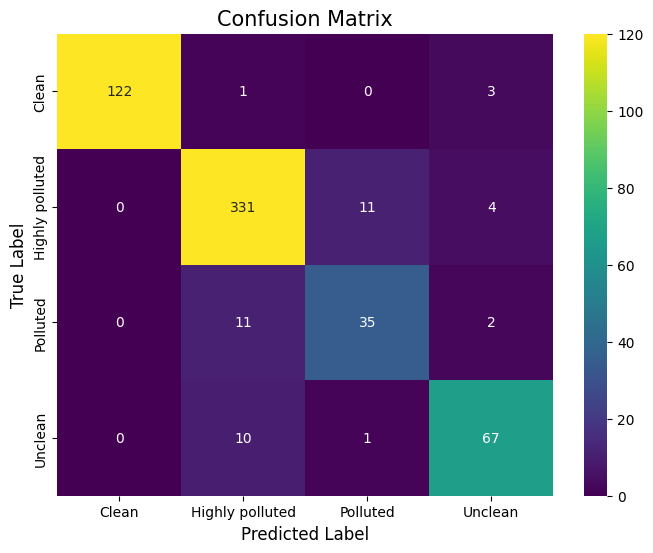

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
class_labels = best_svm_model.classes_  # Assuming y_test is not encoded, else decode it here

# Plot the confusion matrix with heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=True,
            xticklabels=class_labels, yticklabels=class_labels, vmin=0, vmax=120)

# Add labels and title to match the provided image
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=15)

# Display the plot
plt.show()


In [ ]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.0 MB/s eta 0:00:00


**Cat Boost Classifier**

Accuracy: 0.8695652173913043
Precision: 0.8011658404043788
Recall: 0.8695652173913043
F1 Score: 0.8338023655125306
ROC AUC: 0.9561261782542086
Average Precision: 0.9167292149482251


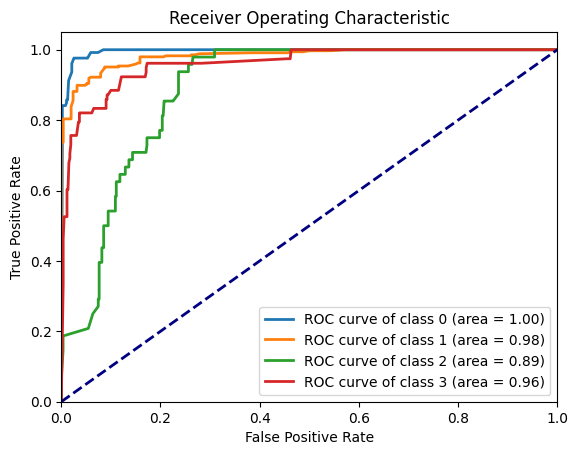

In [ ]:
from catboost import CatBoostClassifier

# Define CATBoost model with provided parameters
catboost_model = CatBoostClassifier(
    iterations=10,
    learning_rate=0.1,
    depth=2,
    loss_function='MultiClass',
    verbose=0  # To avoid printing during training
)

catboost_model.fit(X_train, y_train)

# Predictions
y_pred = catboost_model.predict(X_test)
y_prob = catboost_model.predict_proba(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
avg_precision = average_precision_score(y_test, y_prob, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")
print(f"Average Precision: {avg_precision}")

# ROC Curve
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(catboost_model.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_prob[:, i], pos_label=catboost_model.classes_[i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(len(catboost_model.classes_)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve of class {catboost_model.classes_[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


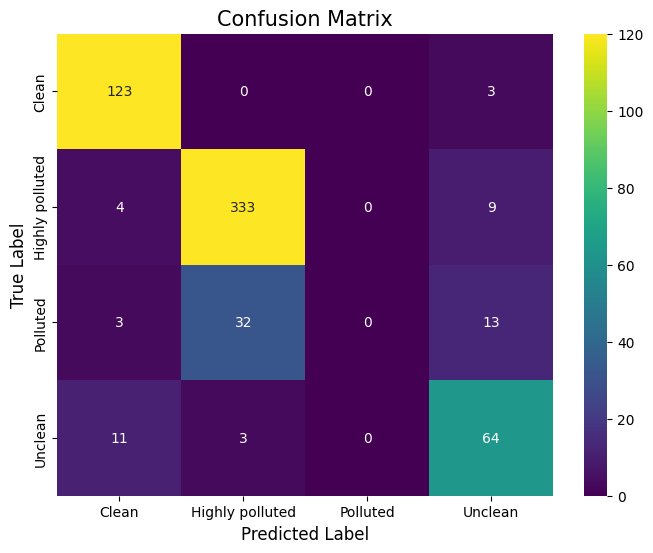

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
class_labels = best_svm_model.classes_  # Assuming y_test is not encoded, else decode it here

# Plot the confusion matrix with heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=True,
            xticklabels=class_labels, yticklabels=class_labels, vmin=0, vmax=120)

# Add labels and title to match the provided image
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=15)

# Display the plot
plt.show()
